In [11]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import trange

import hashlib

In [2]:
def median_scale(x):
    """
    Calculating the median bandwidth parameter of the RBF kernel

    Parameters:
        - x: A tensor of shape (N, D)

    Return:
        - scale: The bandwidth of the RBF kernel using the median trick.
    """

    x_norm = (x ** 2).sum(1).view(-1, 1)
    dist = x_norm + x_norm.t() - 2.0 * torch.mm(x, x.t())
    dist = dist - torch.diag(torch.diag(dist))  # Set the diagonal element to 0
    scale = dist.view(-1).median().sqrt()

    return scale

def compute_mmd(x, y, kernel='rbf', **kwargs):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples, x and y.

    Parameters:
        - x: First set of samples. Shape: (n, d)
        - y: Second set of samples. Shape: (m, d)
        - kernel: Type of kernel to be used. Currently supports 'rbf', 'imq', 'linear', and 'cosine'.
        - **kwargs: Additional keyword arguments for the kernel functions.

    Returns:
        - mmd: The MMD value between x and y.
    """

    def rbf_kernel(x, y, bandwidth=1.0):
        x = x.unsqueeze(1)  # Shape: (n, 1, d)
        y = y.unsqueeze(0)  # Shape: (1, m, d)
        
        # Compute pairwise distances
        distances = (x - y).pow(2).sum(-1)

        return torch.exp(-distances / (2 * bandwidth * bandwidth))

    def imq_kernel(x, y, c=1.0):
        x = x.unsqueeze(1)  # Shape: (n, 1, d)
        y = y.unsqueeze(0)  # Shape: (1, m, d)

        # Compute pairwise distances
        distances = (x - y).pow(2).sum(-1)
        
        return c * c / (c * c + distances)

    def linear_kernel(x, y):
        return torch.mm(x, y.t())

    def cosine_similarity_kernel(x, y):
        x_norm = x / (x.norm(p=2, dim=1, keepdim=True) + 1e-8)
        y_norm = y / (y.norm(p=2, dim=1, keepdim=True) + 1e-8)
        return torch.mm(x_norm, y_norm.t())

    if kernel == 'rbf':
        kernel_func = rbf_kernel
    elif kernel == 'imq':
        kernel_func = imq_kernel
    elif kernel == 'linear':
        kernel_func = linear_kernel
    elif kernel == 'cosine':
        kernel_func = cosine_similarity_kernel
    else:
        raise ValueError("Unsupported kernel type.")

    with torch.no_grad():
        # Compute individual kernel matrices
        xx_kernel = kernel_func(x, x, **kwargs).mean()
        yy_kernel = kernel_func(y, y, **kwargs).mean()
        xy_kernel = kernel_func(x, y, **kwargs).mean()

    # Compute MMD
    mmd = xx_kernel + yy_kernel - 2 * xy_kernel
    return mmd


In [3]:
gs = np.loadtxt('Data/SimpleEggBox.csv', delimiter=',')
DDPG_mcmc_small_total = np.loadtxt('Data/SimpleEggBox_DDPG_small.csv', delimiter=',')

In [4]:
# Gold Standard
gs = np.loadtxt('Data/SimpleEggBox.csv', delimiter=',')

# DDPG
DDPG_mcmc_small_total = np.loadtxt('Data/SimpleEggBox_DDPG_small.csv', delimiter=',')
DDPG_mcmc_small_thinning = DDPG_mcmc_small_total[1::10, :]

DDPG_mcmc_small_plus_total = np.loadtxt('Data/SimpleEggBox_DDPG_small_plus.csv', delimiter=',')
DDPG_mcmc_small_plus_thinning = DDPG_mcmc_small_plus_total[1::10, :]

DDPG_mcmc_small_ultra_total = np.loadtxt('Data/SimpleEggBox_DDPG_small_ultra.csv', delimiter=',')
DDPG_mcmc_small_ultra_thinning = DDPG_mcmc_small_ultra_total[1::10, :]

DDPG_mcmc_medium_total = np.loadtxt('Data/SimpleEggBox_DDPG_medium.csv', delimiter=',')
DDPG_mcmc_medium_thinning = DDPG_mcmc_medium_total[1::10, :]

DDPG_mcmc_medium_plus_total = np.loadtxt('Data/SimpleEggBox_DDPG_medium_plus.csv', delimiter=',')
DDPG_mcmc_medium_plus_thinning = DDPG_mcmc_medium_plus_total[1::10, :]

DDPG_mcmc_medium_ultra_total = np.loadtxt('Data/SimpleEggBox_DDPG_medium_ultra.csv', delimiter=',')
DDPG_mcmc_medium_ultra_thinning = DDPG_mcmc_medium_ultra_total[1::10, :]

DDPG_mcmc_large_total = np.loadtxt('Data/SimpleEggBox_DDPG_large.csv', delimiter=',')
DDPG_mcmc_large_thinning = DDPG_mcmc_large_total[1::10, :]

DDPG_mcmc_large_plus_total = np.loadtxt('Data/SimpleEggBox_DDPG_large_plus.csv', delimiter=',')
DDPG_mcmc_large_plus_thinning = DDPG_mcmc_large_plus_total[1::10, :]

DDPG_mcmc_large_ultra_total = np.loadtxt('Data/SimpleEggBox_DDPG_large_ultra.csv', delimiter=',')
DDPG_mcmc_large_ultra_thinning = DDPG_mcmc_large_ultra_total[1::10, :]

# MALA
MALA_total = np.loadtxt('Data/SimpleEggBox_MALA.csv', delimiter=',')
MALA_thinning = MALA_total[1::10, :]

fisher_MALA_total = np.loadtxt('Data/SimpleEggBox_fisher_MALA.csv', delimiter=',')
fisher_MALA_thinning = fisher_MALA_total[1::10, :]

# MH
rwm_total = np.loadtxt('Data/SimpleEggBox_rwm.csv', delimiter=',')
rwm_thinning = rwm_total[1::10, :]

# NUTS
NUTS_1c_total = np.loadtxt('Data/SimpleEggBox_NUTS_1c.csv', delimiter=',')
NUTS_1c_thinning = NUTS_1c_total[1::10, :]

NUTS_4c_total = np.loadtxt('Data/SimpleEggBox_NUTS_4c.csv', delimiter=',')
NUTS_4c_thinning = NUTS_4c_total[4::10, :]

In [5]:
# Convert to torch GPU tensor

# Gold Standard
gs_gpu = torch.from_numpy(gs).to('cuda').half()

# DDPG
DDPG_mcmc_small_gpu = torch.from_numpy(DDPG_mcmc_small_thinning).to('cuda').half()
DDPG_mcmc_small_plus_gpu = torch.from_numpy(DDPG_mcmc_small_plus_thinning).to('cuda').half()
DDPG_mcmc_small_ultra_gpu = torch.from_numpy(DDPG_mcmc_small_ultra_thinning).to('cuda').half()
DDPG_mcmc_medium_gpu = torch.from_numpy(DDPG_mcmc_medium_thinning).to('cuda').half()
DDPG_mcmc_medium_plus_gpu = torch.from_numpy(DDPG_mcmc_medium_plus_thinning).to('cuda').half()
DDPG_mcmc_medium_ultra_gpu = torch.from_numpy(DDPG_mcmc_medium_ultra_thinning).to('cuda').half()
DDPG_mcmc_large_gpu = torch.from_numpy(DDPG_mcmc_large_thinning).to('cuda').half()
DDPG_mcmc_large_plus_gpu = torch.from_numpy(DDPG_mcmc_large_plus_thinning).to('cuda').half()
DDPG_mcmc_large_ultra_gpu = torch.from_numpy(DDPG_mcmc_large_ultra_thinning).to('cuda').half()

# MALA
MALA_gpu = torch.from_numpy(MALA_thinning).to('cuda').half()
fisher_MALA_gpu = torch.from_numpy(fisher_MALA_thinning).to('cuda').half()

# MH
rwm_gpu = torch.from_numpy(rwm_thinning).to('cuda').half()

# NUTS
NUTS_1c_gpu = torch.from_numpy(NUTS_1c_thinning).to('cuda').half()
NUTS_4c_gpu = torch.from_numpy(NUTS_4c_thinning).to('cuda').half()

# Compute Bandwidth
gs_scale = median_scale(gs_gpu)

# Store MMD
DDPG_mcmc_small_MMD = []
DDPG_mcmc_small_plus_MMD = []
DDPG_mcmc_small_ultra_MMD = []
DDPG_mcmc_medium_MMD = []
DDPG_mcmc_medium_plus_MMD = []
DDPG_mcmc_medium_ultra_MMD = []
DDPG_mcmc_large_MMD = []
DDPG_mcmc_large_plus_MMD = []
DDPG_mcmc_large_ultra_MMD = []

MALA_MMD = []
fisher_MALA_MMD = []

rwm_MMD = []

NUTS_1c_MMD = []
NUTS_4c_MMD = []

In [6]:
# Check Sha256 Hashes
def unique_hashes(*tensors):
    hashes = [hashlib.sha256(tensor.cpu().numpy().tobytes()).hexdigest() for tensor in tensors]
    return len(hashes) == len(set(hashes))

result = unique_hashes(
    DDPG_mcmc_small_gpu,
    DDPG_mcmc_small_plus_gpu,
    DDPG_mcmc_small_ultra_gpu,
    DDPG_mcmc_medium_gpu,
    DDPG_mcmc_medium_plus_gpu,
    DDPG_mcmc_medium_ultra_gpu,
    DDPG_mcmc_large_gpu,
    DDPG_mcmc_large_plus_gpu,
    DDPG_mcmc_large_ultra_gpu
)

assert result == True, "There are duplicate samples!"
del result

In [7]:
for i in [1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]:
    DDPG_mcmc_small_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_small_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_small_MMD.append(DDPG_mcmc_small_mmd_value)
    del DDPG_mcmc_small_mmd_value

    DDPG_mcmc_small_plus_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_small_plus_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_small_plus_MMD.append(DDPG_mcmc_small_plus_mmd_value)
    del DDPG_mcmc_small_plus_mmd_value

    DDPG_mcmc_small_ultra_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_small_ultra_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_small_ultra_MMD.append(DDPG_mcmc_small_ultra_mmd_value)
    del DDPG_mcmc_small_ultra_mmd_value

    DDPG_mcmc_medium_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_medium_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_medium_MMD.append(DDPG_mcmc_medium_mmd_value)
    del DDPG_mcmc_medium_mmd_value

    DDPG_mcmc_medium_plus_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_medium_plus_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_medium_plus_MMD.append(DDPG_mcmc_medium_plus_mmd_value)
    del DDPG_mcmc_medium_plus_mmd_value

    DDPG_mcmc_medium_ultra_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_medium_ultra_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_medium_ultra_MMD.append(DDPG_mcmc_medium_ultra_mmd_value)
    del DDPG_mcmc_medium_ultra_mmd_value

    DDPG_mcmc_large_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_large_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_large_MMD.append(DDPG_mcmc_large_mmd_value)
    del DDPG_mcmc_large_mmd_value

    DDPG_mcmc_large_plus_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_large_plus_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_large_plus_MMD.append(DDPG_mcmc_large_plus_mmd_value)
    del DDPG_mcmc_large_plus_mmd_value

    DDPG_mcmc_large_ultra_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_large_ultra_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    DDPG_mcmc_large_ultra_MMD.append(DDPG_mcmc_large_ultra_mmd_value)
    del DDPG_mcmc_large_ultra_mmd_value

    MALA_mmd_value = compute_mmd(gs_gpu, MALA_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    MALA_MMD.append(MALA_mmd_value)
    del MALA_mmd_value

    fisher_MALA_mmd_value = compute_mmd(gs_gpu, fisher_MALA_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    fisher_MALA_MMD.append(fisher_MALA_mmd_value)
    del fisher_MALA_mmd_value

    rwm_mmd_value = compute_mmd(gs_gpu, rwm_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    rwm_MMD.append(rwm_mmd_value)
    del rwm_mmd_value

    NUTS_1c_mmd_value = compute_mmd(gs_gpu, NUTS_1c_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    NUTS_1c_MMD.append(NUTS_1c_mmd_value)
    del NUTS_1c_mmd_value

    NUTS_4c_mmd_value = compute_mmd(gs_gpu, NUTS_4c_gpu[0:i], kernel='rbf', bandwidth=gs_scale)
    NUTS_4c_MMD.append(NUTS_4c_mmd_value)
    del NUTS_4c_mmd_value


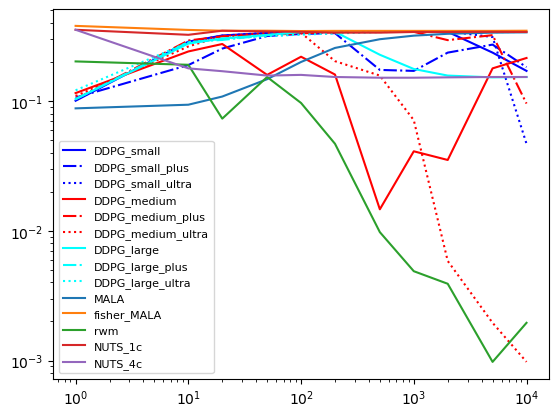

In [8]:
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_small_MMD]), label='DDPG_small', linestyle='-', color='blue')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_small_plus_MMD]), label='DDPG_small_plus', linestyle='-.', color='blue')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_small_ultra_MMD]), label='DDPG_small_ultra', linestyle=':', color='blue')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_medium_MMD]), label='DDPG_medium', linestyle='-', color='red')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_medium_plus_MMD]), label='DDPG_medium_plus', linestyle='-.', color='red')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_medium_ultra_MMD]), label='DDPG_medium_ultra', linestyle=':', color='red')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_large_MMD]), label='DDPG_large', linestyle='-', color='cyan')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_large_plus_MMD]), label='DDPG_large_plus', linestyle='-.', color='cyan')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_large_ultra_MMD]), label='DDPG_large_ultra', linestyle=':', color='cyan')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in MALA_MMD]), label='MALA')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in fisher_MALA_MMD]), label='fisher_MALA')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in rwm_MMD]), label='rwm')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in NUTS_1c_MMD]), label='NUTS_1c')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in NUTS_4c_MMD]), label='NUTS_4c')

plt.legend(loc="lower left", fontsize=8)
plt.savefig('Pic/SimpleEggBox_MMD.png', dpi=300)

In [9]:
df_SimpleEggBox = pd.DataFrame(
    np.vstack((
        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_small_MMD]),
        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_small_plus_MMD]),
        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_small_ultra_MMD]),

        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_medium_MMD]),
        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_medium_plus_MMD]),
        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_medium_ultra_MMD]),

        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_large_MMD]),
        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_large_plus_MMD]),
        np.array([i.to('cpu').numpy() for i in DDPG_mcmc_large_ultra_MMD]),

        np.array([i.to('cpu').numpy() for i in MALA_MMD]),
        np.array([i.to('cpu').numpy() for i in fisher_MALA_MMD]),

        np.array([i.to('cpu').numpy() for i in rwm_MMD]),

        np.array([i.to('cpu').numpy() for i in NUTS_1c_MMD]),
        np.array([i.to('cpu').numpy() for i in NUTS_4c_MMD])
    )).T,
        columns=[
            'DDPG_small',
            'DDPG_small_plus',
            'DDPG_small_ultra',
            'DDPG_medium',
            'DDPG_medium_plus',
            'DDPG_medium_ultra',
            'DDPG_large',
            'DDPG_large_plus',
            'DDPG_large_ultra',
            'MALA',
            'fisher_MALA',
            'rwm',
            'NUTS_1c',
            'NUTS_4c'
                  ]
    )

In [10]:
df_SimpleEggBox.to_csv('Data/SimpleEggBox_MMD.csv', index=False)

In [14]:
df = pd.read_csv('Data/SimpleEggBox_MMD_HPC.csv')

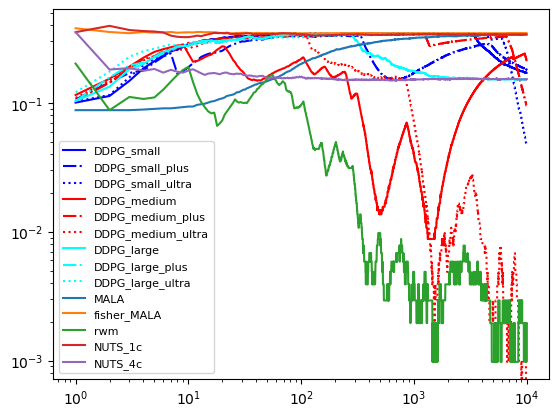

In [15]:
plt.loglog(np.arange(1, 10001), df['DDPG_small'], label='DDPG_small', linestyle='-', color='blue')
plt.loglog(np.arange(1, 10001), df['DDPG_small_plus'], label='DDPG_small_plus', linestyle='-.', color='blue')
plt.loglog(np.arange(1, 10001), df['DDPG_small_ultra'], label='DDPG_small_ultra', linestyle=':', color='blue')

plt.loglog(np.arange(1, 10001), df['DDPG_medium'], label='DDPG_medium', linestyle='-', color='red')
plt.loglog(np.arange(1, 10001), df['DDPG_medium_plus'], label='DDPG_medium_plus', linestyle='-.', color='red')
plt.loglog(np.arange(1, 10001), df['DDPG_medium_ultra'], label='DDPG_medium_ultra', linestyle=':', color='red')

plt.loglog(np.arange(1, 10001), df['DDPG_large'], label='DDPG_large', linestyle='-', color='cyan')
plt.loglog(np.arange(1, 10001), df['DDPG_large_plus'], label='DDPG_large_plus', linestyle='-.', color='cyan')
plt.loglog(np.arange(1, 10001), df['DDPG_large_ultra'], label='DDPG_large_ultra', linestyle=':', color='cyan')

plt.loglog(np.arange(1, 10001), df['MALA'], label='MALA')
plt.loglog(np.arange(1, 10001), df['fisher_MALA'], label='fisher_MALA')

plt.loglog(np.arange(1, 10001), df['rwm'], label='rwm')

plt.loglog(np.arange(1, 10001), df['NUTS_1c'], label='NUTS_1c')
plt.loglog(np.arange(1, 10001), df['NUTS_4c'], label='NUTS_4c')

plt.legend(loc="lower left", fontsize=8)
plt.savefig('Pic/SimpleEggBox_MMD_HPC.png', dpi=300)